In [1]:
%load_ext autotime

In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
from collections import Counter

from covid19_abm.dir_manager import get_data_dir

time: 537 ms


In [3]:
age_map = {
    'less than 1 year': 0,
    'less than 1 year ': 0,
    '1 year': 1,
    '1 year ': 1,
    '2 years': 2,
    '2 years ': 2,
    '98': 98,
    '98 ': 98,
    'not reported/missing': None,
    'not reported/missing ': None,
}

econ_stat_map = {
    'Not working, inactive, not': 'Not working, inactive, not in universe',
}

time: 662 µs


In [4]:
full_individual_df = pd.read_stata(
    get_data_dir('raw', 'census', 'ABM_Simulated_Pop_WardDistributed_UpdatedMay30_school_complete_060520.dta'))

time: 1min 42s


In [5]:
full_individual_df['age'] = full_individual_df['age'].map(lambda x: age_map.get(x, x))
full_individual_df['economic_status'] = full_individual_df['economic_status'].str.strip().map(lambda x: econ_stat_map.get(x, x))

time: 3.5 s


In [6]:
full_individual_df.head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,new_dist_pop_share,geo1_zw,geo1_zw2012,geo1_string,geo2_zw,geo2_zw2012,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile
0,67786,4,21,1,19,female,0,2 families,"domestic and related helpers, cleaners and lau...",2,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
1,64925,3,21,1,49,male,0,2 families,travel attendants and related workers,1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
2,3648785,8,21,1,26,female,Secondary education teaching professionals,4 families,secondary education teaching professionals,2,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
3,127965,6,21,1,54,female,0,2 families,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
4,103824,5,21,1,65,female,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo


time: 29 ms


In [7]:
l = '''Not working, inactive, not in universe
In School
Homemakers/Housework
Office workers
Service Workers
Agriculture Workers
Indusrtry Workers
In the army
Disabled and not working'''
l = l.split('\n')
full_individual_df['economic_status'].value_counts()[l]

Not working, inactive, not in universe    5059625
In School                                 2828795
Homemakers/Housework                      1267806
Office workers                             465489
Service Workers                           2140208
Agriculture Workers                       2309064
Indusrtry Workers                          121116
In the army                                 41494
Disabled and not working                   169548
Name: economic_status, dtype: int64

time: 802 ms


# Fill unknown age

In [8]:
individual_df = full_individual_df

time: 385 µs


In [9]:
# missing_val = 'not reported/missing'
age_cols = ['geo1_zw2012', 'urban', 'persons', 'sex', 'marst', 'citizen', 'race', 'disabled', 'economic_status']
X = pd.get_dummies(individual_df[age_cols], drop_first=True)

X_train = X[individual_df['age'].notnull()]

time: 11.6 s


In [10]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=1029)
# rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=1029, n_jobs=50)

frac = 0.05
X_tr = X_train.sample(frac=frac, random_state=1029)
gb.fit(X_tr, individual_df.loc[X_tr.index, 'age'])

missing_age = X[individual_df['age'].isnull()]

time: 57.4 s


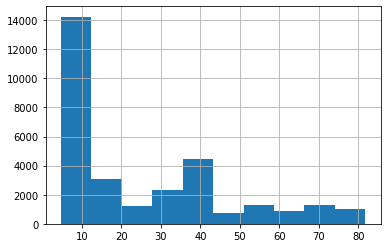

time: 264 ms


In [11]:
pd.Series(gb.predict(missing_age)).hist()

In [12]:
X_tr.shape

(718623, 33)

time: 1.36 ms


In [13]:
individual_df.loc[missing_age.index, 'age'] = gb.predict(missing_age).astype(int)
individual_df.loc[missing_age.index].head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,new_dist_pop_share,geo1_zw,geo1_zw2012,geo1_string,geo2_zw,geo2_zw2012,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile
438,64898,3,21,1,37,male,0,1 family,motor-vehicle drivers,1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
3978,141744,8,21,1,9,male,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
6720,55301,3,21,1,19,male,0,1 family,niu (not in universe),1,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
7963,143945,8,21,1,7,male,0,8 families,niu (not in universe),8,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo
9596,99018,5,21,1,20,female,0,2 families,"domestic and related helpers, cleaners and lau...",2,...,1.0,bulawayo,bulawayo,0,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo


time: 940 ms


In [14]:
individual_df.economic_status.astype(str).value_counts()

Not working, inactive, not in universe    5059625
In School                                 2828795
Agriculture Workers                       2309064
Service Workers                           2140208
Homemakers/Housework                      1267806
Office workers                             465489
Disabled and not working                   169548
Indusrtry Workers                          121116
In the army                                 41494
Name: economic_status, dtype: int64

time: 1.92 s


## Create `ward_id`, `household_id` and `economic_activity_location_id`

In [15]:
relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'ward_id',
    'economic_status', 'economic_activity_location_id',
    # 'household', 'ward'
]

time: 567 µs


In [16]:
old_new_districts = pd.read_csv(
    get_data_dir('raw', 'district_relation.csv', index_col=0))
old_new_districts.index = old_new_districts['ADMIN_NAME'].str.lower()

time: 4.43 ms


In [17]:
individual_df['serial_expanded'] = individual_df['serial']

time: 47.2 ms


In [19]:
individual_df['household_id'] = individual_df['serial_expanded'].map(lambda x: f'h_{x}')
individual_df['old_ward_id'] = individual_df['geo2_zw2012'].map(lambda x: f'w_{old_new_districts["DIST2012"][x]}')                                          
individual_df['new_ward_id'] = individual_df['geo2_zw2012'].map(lambda x: f'w_{old_new_districts["NEW_DIST_ID_2"][x]}')

time: 5.52 s


In [20]:
expanded_individual_df = individual_df.copy()

time: 9.29 s


In [21]:
expanded_individual_df.head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,geo2_zw,geo2_zw2012,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile,serial_expanded,household_id,old_ward_id,new_ward_id
0,67786,4,21,1,19,female,0,2 families,"domestic and related helpers, cleaners and lau...",2,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,67786,h_67786,w_21,w_1
1,64925,3,21,1,49,male,0,2 families,travel attendants and related workers,1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,64925,h_64925,w_21,w_1
2,3648785,8,21,1,26,female,Secondary education teaching professionals,4 families,secondary education teaching professionals,2,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,3648785,h_3648785,w_21,w_1
3,127965,6,21,1,54,female,0,2 families,niu (not in universe),1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,127965,h_127965,w_21,w_1
4,103824,5,21,1,65,female,0,1 family,niu (not in universe),1,...,bulawayo urban,bulawayo urban,bulawayo,1,Bulawayo,Bulawayo,103824,h_103824,w_21,w_1


time: 24.3 ms


In [27]:
expanded_individual_df['school_goers'] = 1 * (expanded_individual_df['school_goers'] != 0)

time: 139 ms


In [28]:
expanded_individual_df.columns

Index(['serial', 'persons', 'district_id', 'new_district_id', 'age', 'sex',
       'teachers', 'nfams', 'isco88a', 'famunit', 'urban', 'economic_status',
       'gq', 'marst', 'citizen', 'race', 'disabled', 'disblnd', 'disdeaf',
       'dismntl', 'famsize', 'age2', 'edattain', 'edattaind', 'yrschool',
       'educzw', 'empstat', 'empstatd', 'labforce', 'occisco', 'occ',
       'manufacturing_workers', 'mining_workers', 'mining_districts', 'pid',
       'weight', 'ward', 'school_goers', 'school_goers_detailed', 'pernum',
       'geolev1', 'Province', 'Province_str', 'ProvincePop2012',
       'ProvincePop2019', 'geolev2', 'new_district_id_st', 'NewDistPop2012',
       'NewDistPop2019', 'new_dist_pop_share', 'geo1_zw', 'geo1_zw2012',
       'geo1_string', 'geo2_zw', 'geo2_zw2012', 'dhs_ipumsi_zw',
       'province_id_shpfile', 'province_name_shpfile', 'district_name_shpfile',
       'serial_expanded', 'household_id', 'old_ward_id', 'new_ward_id'],
      dtype='object')

time: 2.08 ms


In [23]:
expanded_individual_df.groupby('serial')['sex'].count().mean()

3.739394381540564

time: 2.66 s


In [24]:
expanded_individual_df.shape[0] / expanded_individual_df['serial'].nunique()

3.739394381540564

time: 505 ms


In [29]:
(expanded_individual_df['school_goers'] == 1).sum()

2923907

time: 28.4 ms


In [25]:
(expanded_individual_df['school_goers'] == 1).sum()

2518537

time: 22.9 ms


# Mining

In [30]:
# relevant_cols = [
#     'person_id', 'age', 'sex',
#     'household_id', 'ward_id',
#     'economic_status', 'economic_activity_location_id',
#     'school_id_district', 
#     'manufacturing_workers',
#     'mining_district_id'
#     # 'household', 'ward'
# ]

relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'ward_id',
    'economic_status', 'economic_activity_location_id',
    # 'school_id_district', 
    'school_goers',
    'manufacturing_workers',
    # 'mining_district_id'
    # 'household', 'ward'
]

time: 609 µs


In [32]:
mining_df = expanded_individual_df.copy()

p = mining_df['economic_status']

mining_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p == 'Disabled and not working', 'household_id']
mining_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p != 'Disabled and not working', 'new_ward_id']

try:
    mining_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

mining_df['person_id'] = mining_df.index
mining_df['age'] = mining_df['age'].astype(int)
mining_df['economic_status'] = mining_df['economic_status'].str.strip()
mining_df.rename(columns={'new_ward_id': 'ward_id'}, inplace=True)

mining_df[relevant_cols].to_pickle(
    get_data_dir('preprocessed', 'census', 'zimbabwe_ipums_mining_manufacturing_school_new_dist_100pct.pickle'))

time: 40 s


In [33]:
mining_df[relevant_cols].head()

,person_id,age,sex,household_id,ward_id,economic_status,economic_activity_location_id,school_goers,manufacturing_workers
0,0,19,female,h_67786,w_1,Service Workers,w_1,0,0.0
1,1,49,male,h_64925,w_1,Service Workers,w_1,0,0.0
2,2,26,female,h_3648785,w_1,Office workers,w_1,1,0.0
3,3,54,female,h_127965,w_1,Homemakers/Housework,w_1,0,0.0
4,4,65,female,h_103824,w_1,"Not working, inactive, not in universe",w_1,0,0.0


time: 790 ms


# Contingent on available data

In [19]:
# mining_df['serial_expanded'] = mining_df['serial'].map(lambda x: f'{x}_01')
# mining_df['household_id'] = mining_df['serial_expanded'].map(lambda x: f'h_{x}')
mining_df.loc[mining_df['mining_district_id'] != '', 'mining_district_id'] = mining_df.loc[mining_df['mining_district_id'] != '', 'mining_district_id'].map(lambda x: f'mining_{x}')
mining_df.loc[mining_df['school_id_district'] != '', 'school_id_district'] = mining_df.loc[mining_df['school_id_district'] != '', 'school_id_district'].map(lambda x: f'school_{x}')

time: 1.1 s


In [28]:
mining_df.head()

,serial,persons,district_id,new_district_id,age,sex,teachers,nfams,isco88a,famunit,...,dhs_ipumsi_zw,province_id_shpfile,province_name_shpfile,district_name_shpfile,serial_expanded,household_id,old_ward_id,ward_id,economic_activity_location_id,person_id
0,147171,8,21,1,34,female,0,1 family,niu (not in universe),1,...,bulawayo,1,Bulawayo,Bulawayo,147171,h_147171,w_21,w_1,w_1,0
1,21490,2,21,1,36,female,0,1 family,niu (not in universe),1,...,bulawayo,1,Bulawayo,Bulawayo,21490,h_21490,w_21,w_1,w_1,1
2,59596,3,21,1,25,female,0,1 family,"cashiers, tellers and related clerks",1,...,bulawayo,1,Bulawayo,Bulawayo,59596,h_59596,w_21,w_1,w_1,2
3,148162,8,21,1,33,male,0,1 family,"miners, shotfirers, stone cutters and carvers",1,...,bulawayo,1,Bulawayo,Bulawayo,148162,h_148162,w_21,w_1,w_1,3
4,149155,8,21,1,18,female,0,1 family,niu (not in universe),1,...,bulawayo,1,Bulawayo,Bulawayo,149155,h_149155,w_21,w_1,w_1,4


time: 21.7 ms


In [21]:
p = mining_df['economic_status']

mining_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p == 'Disabled and not working', 'household_id']
mining_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p != 'Disabled and not working', 'new_ward_id']

time: 877 ms


In [22]:
try:
    mining_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

mining_df['person_id'] = mining_df.index
mining_df['age'] = mining_df['age'].astype(int)
mining_df['economic_status'] = mining_df['economic_status'].str.strip()
mining_df.rename(columns={'new_ward_id': 'ward_id'}, inplace=True)

time: 1.21 s


time: 870 µs


In [24]:
mining_df[relevant_cols][
    mining_df.serial_expanded.str.endswith('_01')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_5pct.pickle')

time: 932 ms


In [25]:
mining_df[relevant_cols][
    mining_df.serial_expanded.str.endswith('_01') | mining_df.serial_expanded.str.endswith('_02')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

time: 1.73 s


In [26]:
mining_df.shape

(1309376, 69)

time: 2.32 ms


In [2]:
import pandas as pd

In [3]:
mining_df = pd.read_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

In [9]:
mining_df[mining_df['school_id_district'] != '']['person_id']

1              1
2              2
3              3
10            10
20            20
           ...  
654638    654638
654646    654646
654647    654647
654656    654656
654682    654682
Name: person_id, Length: 126990, dtype: int64

# Expand to 10%

In [23]:
mining_df

,serial,persons,hhwt,subsamp,strata,gq,urban,geolev1,Province,Province_str,...,manufacturing_workers,mining_workers,mining_districts,mining_district_id,serial_expanded,household_id,old_ward_id,ward_id,economic_activity_location_id,person_id
0,4908000,4,20,10th 1% subsample,12552,households,urban,716000,0,bulawayo,...,NaN,NaN,NaN,,4908000_01,h_4908000_01,w_21,w_1,w_1,0
1,944000,5,20,44th 1% subsample,893,households,urban,716000,0,bulawayo,...,NaN,NaN,NaN,,944000_01,h_944000_01,w_21,w_1,w_1,1
2,5669000,4,20,9th 1% subsample,6838,households,urban,716000,0,bulawayo,...,NaN,NaN,NaN,,5669000_01,h_5669000_01,w_21,w_1,w_1,2
3,3231000,8,20,37th 1% subsample,9404,households,urban,716000,0,bulawayo,...,NaN,NaN,NaN,,3231000_01,h_3231000_01,w_21,w_1,w_1,3
4,1544000,6,20,44th 1% subsample,3738,households,urban,716000,0,bulawayo,...,NaN,NaN,NaN,,1544000_01,h_1544000_01,w_21,w_1,w_1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654683,107627000,8,20,4th 1% subsample,1741,households,rural,716007,7,midlands,...,NaN,NaN,NaN,,107627000_01,h_107627000_01,w_708,w_60,w_60,654683
654684,112072000,6,20,62nd 1% subsample,2077,households,urban,716007,7,midlands,...,NaN,NaN,NaN,,112072000_01,h_112072000_01,w_724,w_60,w_60,654684
654685,107362000,8,20,5th 1% subsample,13286,households,rural,716007,7,midlands,...,NaN,NaN,NaN,,107362000_01,h_107362000_01,w_708,w_60,w_60,654685
654686,107396000,8,20,79th 1% subsample,4246,households,rural,716007,7,midlands,...,NaN,NaN,NaN,,107396000_01,h_107396000_01,w_708,w_60,w_60,654686


time: 261 ms


# Scratch

In [32]:
mining_df[~mining_df['household_id'].str.startswith('h_')]['person_id'].values

array([   298,    315,    325, ..., 654637, 654654, 654659])

time: 143 ms


In [43]:
mining_df[mining_df.manufacturing_workers.notnull()].person_id

5              5
95            95
251          251
274          274
302          302
           ...  
654084    654084
654108    654108
654170    654170
654335    654335
654571    654571
Name: person_id, Length: 10471, dtype: int64

time: 16.8 ms


In [44]:
mining_df[mining_df['manufacturing_workers'].notnull()]['person_id'].values

array([     5,     95,    251, ..., 654170, 654335, 654571])

time: 16.3 ms


In [51]:
mining_df[mining_df['school_id_district'] != '']['person_id'].values

(63495,)

time: 46.2 ms


In [52]:
mining_df['school_id_district'].shape

(654688,)

time: 2.91 ms
